In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 5000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 200), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
X['pred_AD_score'] = if_model.decision_function(X[features])
X['pred_AD_score'] = -1*X['pred_AD_score']
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5195,9.286361,9.509855,7.420566,5.489620,6.507324,5.166226,1,0.072940
5196,10.428030,9.279504,7.351142,7.325884,4.020664,4.780317,1,0.134323
5197,9.759669,9.173396,9.347484,3.279202,7.090828,3.164443,1,0.164116
5198,8.169076,9.438252,8.083111,4.274454,4.842045,5.137235,1,0.041461
5199,10.444451,9.713754,7.680821,4.291069,5.026204,5.108592,1,0.089395


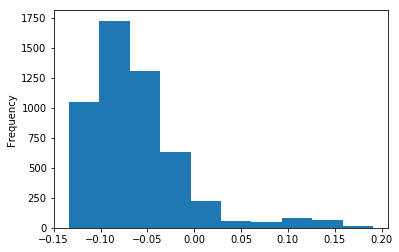

In [11]:
X['pred_AD_score'].plot(kind='hist')

In [12]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [13]:
top_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [14]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5187,9.149145,12.128410,8.442306,4.970936,2.108202,7.927851,1,0.190983
5162,11.953671,9.575762,8.896266,5.871586,6.885468,6.812117,1,0.182636
5057,9.327178,10.967273,8.130969,7.603339,2.799039,5.948372,1,0.178090
5064,9.574870,9.332791,7.974137,6.716454,7.684106,3.320290,1,0.175041
5129,11.197418,9.801724,9.688974,6.418845,7.043577,4.562910,1,0.174094
5099,9.768291,10.295294,9.599812,6.233541,5.375745,6.956792,1,0.171267
5186,11.316763,9.505782,8.690792,2.850596,5.284171,7.112663,1,0.169484
5069,9.751259,10.455308,9.336925,7.009666,4.352136,4.638764,1,0.165808
5095,9.067634,10.145145,9.869404,8.175609,5.669449,4.532827,1,0.165509
5197,9.759669,9.173396,9.347484,3.279202,7.090828,3.164443,1,0.164116


In [15]:
k = 20
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return -1*df

acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.fit(X[features], robust = True)

In [16]:
#acme_local = acme_ifo.fit_local(X[features], top_anomalies.index[-1])
acme_local = acme_ifo.fit_local(X[features], bottom_anomalies.index[-1])
#acme_local = acme_ifo.fit_local(X[features], top_normal.index[-1])
#acme_local = acme_ifo.fit_local(X[features], bottom_normal.index[-1])

In [18]:
local_table = acme_local.summary_table(local=True)

In [19]:
acme_local.feature_importance()

,importance
feature,
f1,0.026837
f2,0.023960
f3,0.023646
f4,0.022846
f6,0.021671
f5,0.012794


In [29]:
acme_local.feature_exploration('f3',local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile,size,importance,direction
feature,,,,,,,,,,
f3,0.040652,0.050793,0.010141,1.562660,0.000000,numeric,0.949038,0.2,0.033809,anomalies
f3,-0.024887,-0.014746,0.010141,3.478720,0.055556,numeric,0.949038,0.2,0.033809,normal
f3,-0.033787,-0.023646,0.010141,3.837116,0.111111,numeric,0.949038,0.2,0.033809,normal
f3,-0.040343,-0.030202,0.010141,4.086642,0.166667,numeric,0.949038,0.2,0.033809,normal
f3,-0.043690,-0.033549,0.010141,4.282611,0.222222,numeric,0.949038,0.2,0.033809,normal
f3,-0.049075,-0.038935,0.010141,4.460777,0.277778,numeric,0.949038,0.2,0.033809,normal
f3,-0.051664,-0.041523,0.010141,4.622616,0.333333,numeric,0.949038,0.2,0.033809,normal
f3,-0.053525,-0.043384,0.010141,4.770929,0.388889,numeric,0.949038,0.2,0.033809,normal
f3,-0.053119,-0.042978,0.010141,4.910369,0.444444,numeric,0.949038,0.2,0.033809,normal


In [30]:
acme_local.feature_exploration('f3',local=True,plot=True)

In [31]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
3260,5.379684,5.410539,7.111602,5.744589,6.214112,7.478184


In [32]:
acme_local.summary_plot(local=True)

In [33]:
acme_local.summary_plot()

In [34]:
acme_local.summary_table()

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile,importance
feature,,,,,,,,
f1,0.074822,-0.100818,-0.13572,3.405294,0.05,numeric,0.558077,0.026837
f1,0.039133,-0.113016,-0.13572,3.753611,0.10,numeric,0.558077,0.026837
f1,0.015921,-0.120949,-0.13572,4.018407,0.15,numeric,0.558077,0.026837
f1,-0.002154,-0.127126,-0.13572,4.224018,0.20,numeric,0.558077,0.026837
f1,-0.011886,-0.130452,-0.13572,4.386154,0.25,numeric,0.558077,0.026837
...,...,...,...,...,...,...,...,...
f6,-0.014112,-0.132299,-0.13572,5.664266,0.75,numeric,0.508654,0.021671
f6,0.000727,-0.126601,-0.13572,5.838906,0.80,numeric,0.508654,0.021671
f6,0.018128,-0.119918,-0.13572,6.041437,0.85,numeric,0.508654,0.021671
